
## **Core Analyses Performed:**

### **1. Data Loading & API Integration**
- Queries PanKbase API for metadata on each analysis set
- Loads DEG results from S3 for all 5 cell types (Alpha, Beta, ActiveStellate, Acinar, Ductal)
- Combines datasets with proper cell type labeling

### **2. Volcano Plots**
- Individual volcano plots for each cell type
- Color-coded significance levels (upregulated/downregulated/significant/not significant)
- Thresholds: padj < 0.05 and |log2FC| > 1


### **3. Comparative Analysis**
- **Common genes**: DEGs shared across multiple cell types
- **Cell-type specific genes**: DEGs unique to single cell types
- **Summary statistics**: Total DEGs, up/downregulated counts per cell type

### **4. Additional Analyses**
- **Summary bar plot**: Visual comparison of DEG counts across cell types
- **Gene list preparation**: Ready-to-use lists for GO/KEGG enrichment analysis
- **Statistical summaries**: Comprehensive overview of results

## **Key Features:**
- **Robust error handling** for API calls and file loading
- **Flexible visualization** with customizable significance thresholds
- **Functional analysis preparation** with gene lists for downstream enrichment
- **Comprehensive reporting** with detailed statistics and summaries

## **Expected Outputs:**
- 5 volcano plots (one per cell type)
- Summary tables of DEG statistics
- Lists of cell-type specific and shared DEGs
- Bar plot comparing DEG counts across cell types

In [1]:
# === USER CONFIGURATION VARIABLES ===
# Modify these values to customize your analysis
LOG2FC_THRESHOLD <- 1.0         # Log2 fold change threshold for significance
PVALUE_THRESHOLD <- 0.05        # Adjusted p-value threshold  
MIN_BASEMEAN <- 10             # Minimum base mean expression level
TOP_GENES_TABLE <- 10          # Number of top genes to display in tables
PLOT_POINT_SIZE <- 0.8         # Size of points in volcano plots
PLOT_ALPHA <- 0.6              # Transparency of points in plots
VOLCANO_COLORS <- list(        # Colors for volcano plot categories
  "Not Significant" = "grey70",
  "Significant" = "gold", 
  "Upregulated" = "red2",
  "Downregulated" = "blue2"
)

# === DEFAULTS (DO NOT MODIFY - automatic fallbacks) ===
LOG2FC_THRESHOLD <- ifelse(exists("LOG2FC_THRESHOLD") && !is.null(LOG2FC_THRESHOLD), LOG2FC_THRESHOLD, 1.0)
PVALUE_THRESHOLD <- ifelse(exists("PVALUE_THRESHOLD") && !is.null(PVALUE_THRESHOLD), PVALUE_THRESHOLD, 0.05)
MIN_BASEMEAN <- ifelse(exists("MIN_BASEMEAN") && !is.null(MIN_BASEMEAN), MIN_BASEMEAN, 10)
TOP_GENES_TABLE <- ifelse(exists("TOP_GENES_TABLE") && !is.null(TOP_GENES_TABLE), TOP_GENES_TABLE, 10)
PLOT_POINT_SIZE <- ifelse(exists("PLOT_POINT_SIZE") && !is.null(PLOT_POINT_SIZE), PLOT_POINT_SIZE, 0.8)
PLOT_ALPHA <- ifelse(exists("PLOT_ALPHA") && !is.null(PLOT_ALPHA), PLOT_ALPHA, 0.6)

cat("=== ANALYSIS PARAMETERS ===\n")
cat("Log2FC threshold:", LOG2FC_THRESHOLD, "\n")
cat("P-value threshold:", PVALUE_THRESHOLD, "\n")
cat("Minimum base mean:", MIN_BASEMEAN, "\n")
cat("================================\n\n")

# Load required libraries
suppressMessages({
  library(httr)
  library(jsonlite)
  library(ggplot2)
  library(dplyr)
  library(readr)
  library(tidyr)
})

cat("Libraries loaded successfully!\n")

=== ANALYSIS PARAMETERS ===
Log2FC threshold: 1 
P-value threshold: 0.05 
Minimum base mean: 10 

Libraries loaded successfully!


In [2]:
# Start timing
start_time <- Sys.time()
cat("Analysis started at:", format(start_time), "\n")

# Define datasets
datasets <- list(
  "Alpha" = list(
    analysis_id = "PKBDS5505XMWS",
    deg_url = "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/Alpha_k-chosen_fdr0.05_all.txt"
  ),
  "Beta" = list(
    analysis_id = "PKBDS3519RAFX", 
    deg_url = "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/Beta_k-chosen_fdr0.05_all.txt"
  ),
  "ActiveStellate" = list(
    analysis_id = "PKBDS3483TGEQ",
    deg_url = "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/ActiveStellate_k-chosen_fdr0.05_all.txt"
  ),
  "Acinar" = list(
    analysis_id = "PKBDS6610NSWK",
    deg_url = "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/Acinar_k-chosen_fdr0.05_all.txt"
  ),
  "Ductal" = list(
    analysis_id = "PKBDS8497JAAX",
    deg_url = "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/Ductal_k-chosen_fdr0.05_all.txt"
  )
)

# Base URLs
base_url <- "https://api.data.pankbase.org"

# Function to safely query API
safe_api_query <- function(url) {
  tryCatch({
    response <- GET(url)
    if (status_code(response) == 200) {
      return(fromJSON(content(response, "text", encoding = "UTF-8")))
    } else {
      warning(paste("API request failed for:", url, "Status:", status_code(response)))
      return(NULL)
    }
  }, error = function(e) {
    warning(paste("Error querying:", url, "-", e$message))
    return(NULL)
  })
}

# Function to load DEG data from S3
load_deg_data <- function(url, cell_type) {
  cat("Loading DEG data for", cell_type, "from S3...\n")
  tryCatch({
    options(timeout = 300)
    deg_data <- read_tsv(url, show_col_types = FALSE)
    deg_data$cell_type <- cell_type
    cat("✓ Successfully loaded", nrow(deg_data), "genes for", cell_type, "\n")
    return(deg_data)
  }, error = function(e) {
    warning(paste("✗ Failed to load DEG data for", cell_type, ":", e$message))
    return(NULL)
  })
}

# Function to create volcano plot
create_volcano_plot <- function(data, title) {
  # Filter by minimum base mean
  data <- data %>% filter(baseMean >= MIN_BASEMEAN)
  
  # Add significance categories using user-defined thresholds
  data$significance <- "Not Significant"
  data$significance[data$padj < PVALUE_THRESHOLD & data$log2FoldChange > LOG2FC_THRESHOLD] <- "Upregulated"
  data$significance[data$padj < PVALUE_THRESHOLD & data$log2FoldChange < -LOG2FC_THRESHOLD] <- "Downregulated"
  data$significance[data$padj < PVALUE_THRESHOLD & abs(data$log2FoldChange) < LOG2FC_THRESHOLD] <- "Significant"
  
  # Create plot with user-defined parameters
  p <- ggplot(data, aes(x = log2FoldChange, y = -log10(padj), color = significance)) +
    geom_point(alpha = PLOT_ALPHA, size = PLOT_POINT_SIZE) +
    scale_color_manual(values = VOLCANO_COLORS) +
    geom_vline(xintercept = c(-LOG2FC_THRESHOLD, LOG2FC_THRESHOLD), linetype = "dashed", alpha = 0.5) +
    geom_hline(yintercept = -log10(PVALUE_THRESHOLD), linetype = "dashed", alpha = 0.5) +
    labs(
      title = paste("Volcano Plot -", title),
      x = "Log2 Fold Change",
      y = "-Log10 Adjusted P-value",
      color = "Significance",
      subtitle = paste("Thresholds: |log2FC| >", LOG2FC_THRESHOLD, ", padj <", PVALUE_THRESHOLD)
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      legend.position = "bottom"
    )
  
  return(p)
}

cat("Functions defined successfully!\n")

Analysis started at: 2025-06-25 14:15:32 
Functions defined successfully!


In [3]:
# Load all datasets
cat("=== LOADING DEG DATASETS ===\n")
all_deg_data <- list()
metadata_list <- list()

for (cell_type in names(datasets)) {
  cat("\n--- Processing", cell_type, "---\n")
  
  # Query API for metadata
  analysis_url <- paste0(base_url, "/analysis-sets/", datasets[[cell_type]]$analysis_id, "/")
  metadata <- safe_api_query(analysis_url)
  
  if (!is.null(metadata)) {
    cat("Analysis description:", metadata$description, "\n")
    metadata_list[[cell_type]] <- metadata
  }
  
  # Load DEG data
  deg_data <- load_deg_data(datasets[[cell_type]]$deg_url, cell_type)
  if (!is.null(deg_data)) {
    all_deg_data[[cell_type]] <- deg_data
  }
}

# Check if data was loaded successfully
if (length(all_deg_data) == 0) {
  stop("No DEG data was successfully loaded. Check internet connection and URLs.")
}

# Combine all DEG data
combined_deg <- do.call(rbind, all_deg_data)
cat("\n SUCCESS! Combined dataset contains", nrow(combined_deg), "total entries across", 
    length(unique(combined_deg$cell_type)), "cell types\n")

# Quick data preview
cat("\nData preview:\n")
print(head(combined_deg, 3))

=== LOADING DEG DATASETS ===

--- Processing Alpha ---
Analysis description: RUV-normalized pseudo-bulk counts for differential expression analysis of pancreatic D cell derived from cells in the single cell RNA-seq browser v3.3 
Loading DEG data for Alpha from S3...
✓ Successfully loaded 13651 genes for Alpha 

--- Processing Beta ---
Analysis description: RUV-normalized pseudo-bulk counts for differential expression analysis of type B pancreatic cell derived from cells in the single cell RNA-seq browser v3.3 
Loading DEG data for Beta from S3...
✓ Successfully loaded 13191 genes for Beta 

--- Processing ActiveStellate ---
Analysis description: RUV-normalized pseudo-bulk counts for differential expression analysis of pancreatic stellate cell derived from cells in the single cell RNA-seq browser v3.3 
Loading DEG data for ActiveStellate from S3...
✓ Successfully loaded 10621 genes for ActiveStellate 

--- Processing Acinar ---
Analysis description: RUV-normalized pseudo-bulk counts for

In [4]:
# === SUMMARY STATISTICS ===
cat("=== SUMMARY STATISTICS ===\n")
summary_stats <- combined_deg %>%
  filter(baseMean >= MIN_BASEMEAN) %>%
  group_by(cell_type) %>%
  summarise(
    total_genes = n(),
    upregulated = sum(log2FoldChange > LOG2FC_THRESHOLD & padj < PVALUE_THRESHOLD, na.rm = TRUE),
    downregulated = sum(log2FoldChange < -LOG2FC_THRESHOLD & padj < PVALUE_THRESHOLD, na.rm = TRUE),
    significant = sum(padj < PVALUE_THRESHOLD, na.rm = TRUE),
    .groups = 'drop'
  )

print(summary_stats)

# Show percentage breakdown
cat("\nPercentage breakdown:\n")
summary_with_pct <- summary_stats %>%
  mutate(
    pct_upregulated = round(100 * upregulated / total_genes, 1),
    pct_downregulated = round(100 * downregulated / total_genes, 1),
    pct_significant = round(100 * significant / total_genes, 1)
  )
print(summary_with_pct)

=== SUMMARY STATISTICS ===
# A tibble: 5 × 5
  cell_type      total_genes upregulated downregulated significant
  <chr>                <int>       <int>         <int>       <int>
1 Acinar               10260          86             1         194
2 ActiveStellate        9256          24            12          36
3 Alpha                12487          14             9          32
4 Beta                 11742         210           105         939
5 Ductal               10715          17             6          82

Percentage breakdown:
# A tibble: 5 × 8
  cell_type    total_genes upregulated downregulated significant pct_upregulated
  <chr>              <int>       <int>         <int>       <int>           <dbl>
1 Acinar             10260          86             1         194             0.8
2 ActiveStell…        9256          24            12          36             0.3
3 Alpha              12487          14             9          32             0.1
4 Beta               11742         210  

Creating Alpha Cell Volcano Plot

 Alpha Cell Statistics:
Total genes: 12487 
Upregulated: 14 
Downregulated: 9 
 Creating Beta Cell Volcano Plot


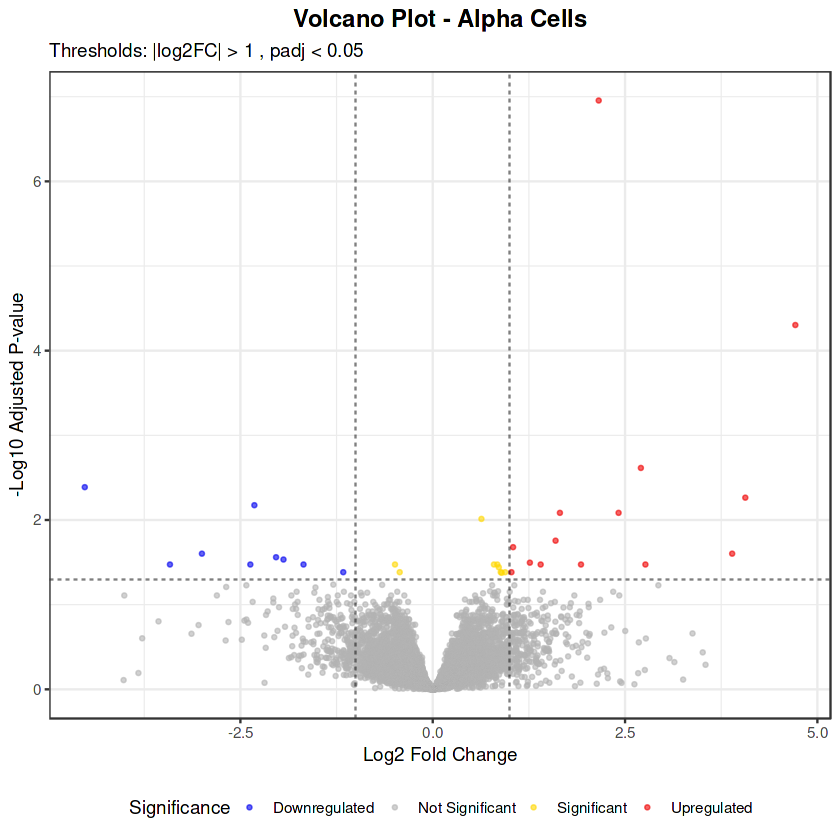


 Beta Cell Statistics:
Total genes: 11742 
Upregulated: 210 
Downregulated: 105 
 Creating Active Stellate Cell Volcano Plot


Warning message:
“Removed 4607 rows containing missing values or values outside the scale range
(`geom_point()`).”


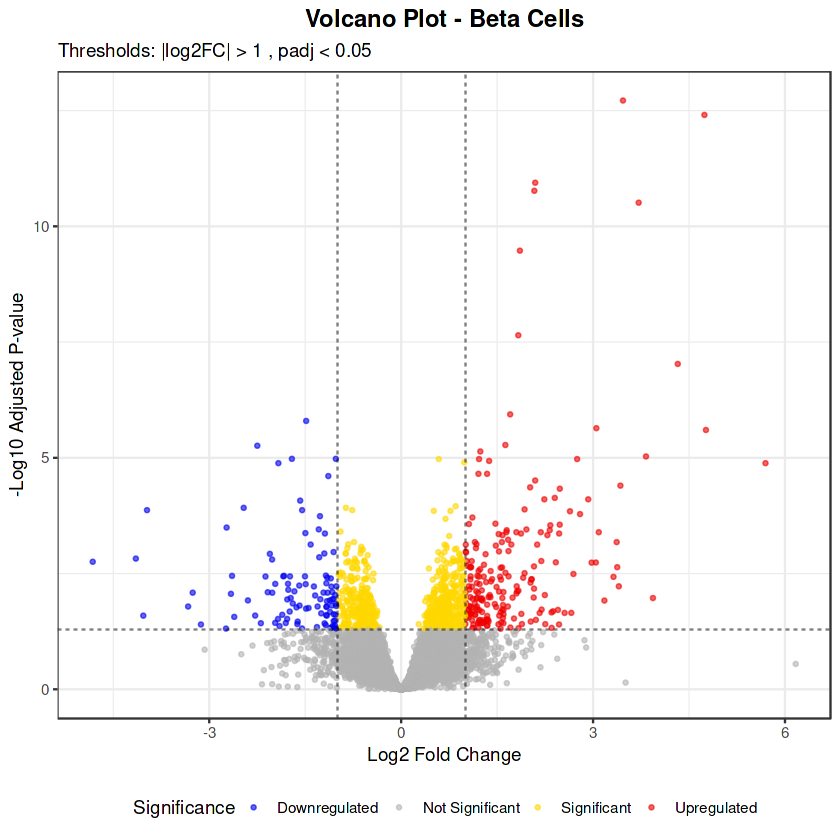


 Active Stellate Cell Statistics:
Total genes: 9256 
Upregulated: 24 
Downregulated: 12 
 Creating Acinar Cell Volcano Plot


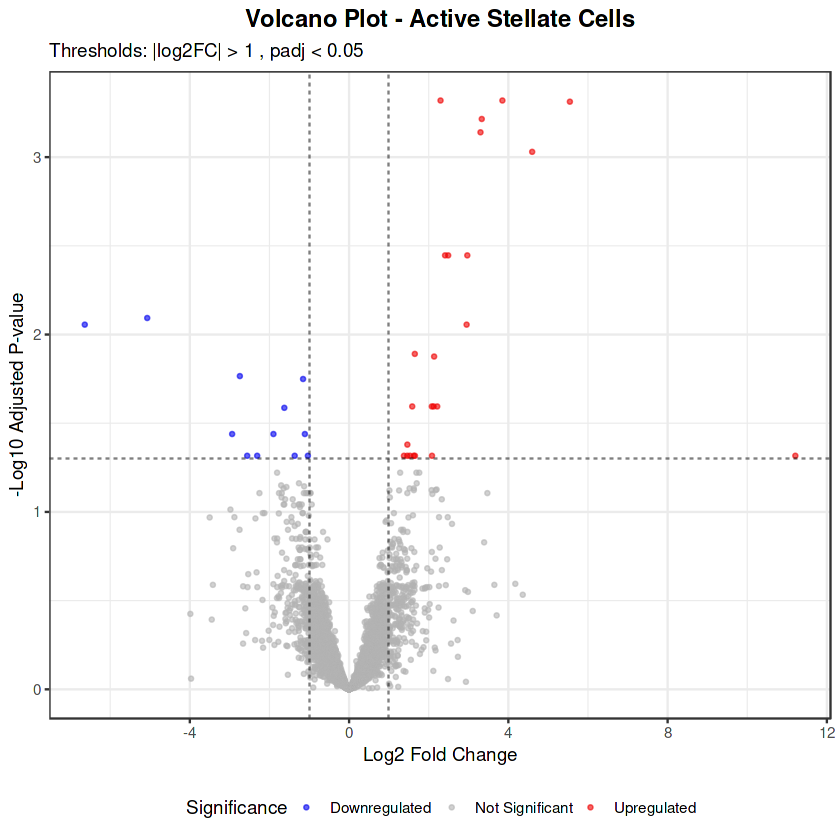


 Acinar Cell Statistics:
Total genes: 10260 
Upregulated: 86 
Downregulated: 1 
 Creating Ductal Cell Volcano Plot


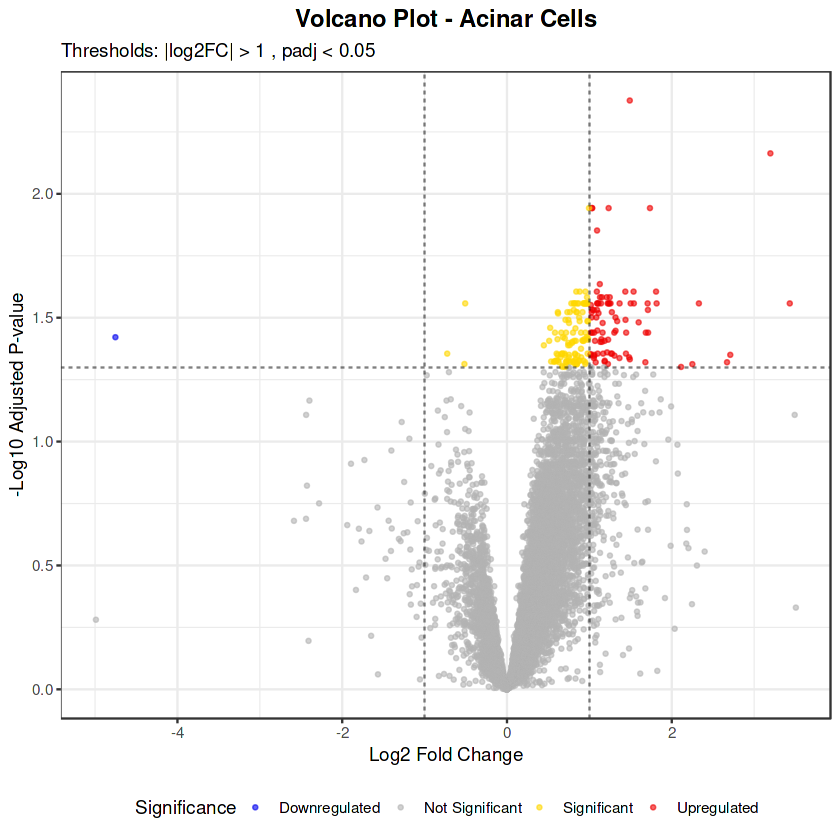


 Ductal Cell Statistics:
Total genes: 10715 
Upregulated: 17 
Downregulated: 6 


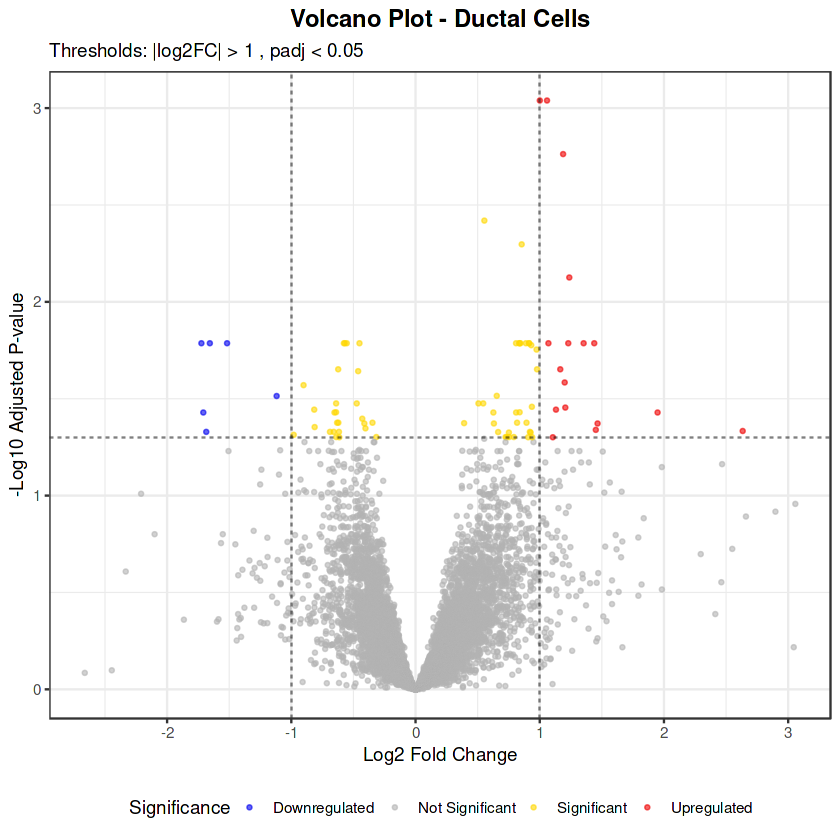

In [5]:
# === ALPHA CELL VOLCANO PLOT ===
cat("Creating Alpha Cell Volcano Plot\n")

if ("Alpha" %in% names(all_deg_data)) {
  alpha_plot <- create_volcano_plot(all_deg_data[["Alpha"]], "Alpha Cells")
  print(alpha_plot)
  
  # Show Alpha-specific stats
  alpha_stats <- summary_stats %>% filter(cell_type == "Alpha")
  cat("\n Alpha Cell Statistics:\n")
  cat("Total genes:", alpha_stats$total_genes, "\n")
  cat("Upregulated:", alpha_stats$upregulated, "\n") 
  cat("Downregulated:", alpha_stats$downregulated, "\n")
} else {
  cat("Alpha data not available\n")
}
# === BETA CELL VOLCANO PLOT ===
cat(" Creating Beta Cell Volcano Plot\n")

if ("Beta" %in% names(all_deg_data)) {
  beta_plot <- create_volcano_plot(all_deg_data[["Beta"]], "Beta Cells")
  print(beta_plot)
  
  # Show Beta-specific stats
  beta_stats <- summary_stats %>% filter(cell_type == "Beta")
  cat("\n Beta Cell Statistics:\n")
  cat("Total genes:", beta_stats$total_genes, "\n")
  cat("Upregulated:", beta_stats$upregulated, "\n") 
  cat("Downregulated:", beta_stats$downregulated, "\n")
} else {
  cat(" Beta data not available\n")
}
# === ACTIVE STELLATE CELL VOLCANO PLOT ===
cat(" Creating Active Stellate Cell Volcano Plot\n")

if ("ActiveStellate" %in% names(all_deg_data)) {
  stellate_plot <- create_volcano_plot(all_deg_data[["ActiveStellate"]], "Active Stellate Cells")
  print(stellate_plot)
  
  # Show ActiveStellate-specific stats
  stellate_stats <- summary_stats %>% filter(cell_type == "ActiveStellate")
  cat("\n Active Stellate Cell Statistics:\n")
  cat("Total genes:", stellate_stats$total_genes, "\n")
  cat("Upregulated:", stellate_stats$upregulated, "\n") 
  cat("Downregulated:", stellate_stats$downregulated, "\n")
} else {
  cat(" Active Stellate data not available\n")
}
# === ACINAR CELL VOLCANO PLOT ===
cat(" Creating Acinar Cell Volcano Plot\n")

if ("Acinar" %in% names(all_deg_data)) {
  acinar_plot <- create_volcano_plot(all_deg_data[["Acinar"]], "Acinar Cells")
  print(acinar_plot)
  
  # Show Acinar-specific stats
  acinar_stats <- summary_stats %>% filter(cell_type == "Acinar")
  cat("\n Acinar Cell Statistics:\n")
  cat("Total genes:", acinar_stats$total_genes, "\n")
  cat("Upregulated:", acinar_stats$upregulated, "\n") 
  cat("Downregulated:", acinar_stats$downregulated, "\n")
} else {
  cat(" Acinar data not available\n")
}
# === DUCTAL CELL VOLCANO PLOT ===
cat(" Creating Ductal Cell Volcano Plot\n")

if ("Ductal" %in% names(all_deg_data)) {
  ductal_plot <- create_volcano_plot(all_deg_data[["Ductal"]], "Ductal Cells")
  print(ductal_plot)
  
  # Show Ductal-specific stats
  ductal_stats <- summary_stats %>% filter(cell_type == "Ductal")
  cat("\n Ductal Cell Statistics:\n")
  cat("Total genes:", ductal_stats$total_genes, "\n")
  cat("Upregulated:", ductal_stats$upregulated, "\n") 
  cat("Downregulated:", ductal_stats$downregulated, "\n")
} else {
  cat(" Ductal data not available\n")
}

In [6]:
# === COMPARATIVE ANALYSIS ===
cat(" COMPARATIVE ANALYSIS\n")

# Find common significantly upregulated genes
sig_up_genes <- combined_deg %>%
  filter(baseMean >= MIN_BASEMEAN & padj < PVALUE_THRESHOLD & log2FoldChange > LOG2FC_THRESHOLD) %>%
  group_by(gene) %>%
  summarise(
    cell_types = paste(cell_type, collapse = ", "),
    n_cell_types = n(),
    avg_log2fc = mean(log2FoldChange),
    .groups = 'drop'
  ) %>%
  arrange(desc(n_cell_types), desc(avg_log2fc))

cat("\n Top genes upregulated across multiple cell types:\n")
multi_cell_genes <- sig_up_genes %>% filter(n_cell_types > 1) %>% head(TOP_GENES_TABLE)
if (nrow(multi_cell_genes) > 0) {
  print(multi_cell_genes)
} else {
  cat("No genes are upregulated across multiple cell types with current thresholds.\n")
}

# Find cell-type specific genes
specific_genes <- combined_deg %>%
  filter(baseMean >= MIN_BASEMEAN & padj < PVALUE_THRESHOLD & abs(log2FoldChange) > LOG2FC_THRESHOLD) %>%
  group_by(gene) %>%
  filter(n() == 1) %>%
  ungroup() %>%
  arrange(cell_type, desc(abs(log2FoldChange)))

cat("\n Cell-type specific DEGs (top", TOP_GENES_TABLE/2, "per cell type):\n")
specific_summary <- specific_genes %>%
  group_by(cell_type) %>%
  slice_head(n = TOP_GENES_TABLE/2) %>%
  select(cell_type, gene, log2FoldChange, padj)

if (nrow(specific_summary) > 0) {
  print(specific_summary)
} else {
  cat("No cell-type specific genes found with current thresholds.\n")
}

 COMPARATIVE ANALYSIS

 Top genes upregulated across multiple cell types:
# A tibble: 10 × 4
   gene     cell_types             n_cell_types avg_log2fc
   <chr>    <chr>                         <int>      <dbl>
 1 GBP1     Alpha, Acinar                     2       3.20
 2 ARL14EPL Alpha, Beta                       2       3.12
 3 HLA-B    Alpha, Beta                       2       2.94
 4 ETV7     Alpha, Beta                       2       2.87
 5 UBD      Acinar, Ductal                    2       2.65
 6 ODF3B    Alpha, Beta                       2       2.38
 7 IRF1     Alpha, Beta                       2       2.07
 8 GPS2     ActiveStellate, Acinar            2       1.97
 9 HLA-C    Alpha, Beta                       2       1.56
10 BCL6     Alpha, Beta                       2       1.54

 Cell-type specific DEGs (top 5 per cell type):
# A tibble: 25 × 4
# Groups:   cell_type [5]
   cell_type      gene            log2FoldChange     padj
   <chr>          <chr>                    <dbl

In [7]:
# === FUNCTIONAL ANALYSIS PREPARATION ===
cat(" PREPARING GENE LISTS FOR FUNCTIONAL ANALYSIS\n")

# Create gene lists for each cell type
gene_lists <- list()
for (cell_type in names(all_deg_data)) {
  if (!is.null(all_deg_data[[cell_type]])) {
    # Filter by minimum base mean and user-defined thresholds
    filtered_data <- all_deg_data[[cell_type]] %>%
      filter(baseMean >= MIN_BASEMEAN)
    
    # Upregulated genes
    gene_lists[[paste0(cell_type, "_up")]] <- filtered_data %>%
      filter(padj < PVALUE_THRESHOLD & log2FoldChange > LOG2FC_THRESHOLD) %>%
      pull(gene)
    
    # Downregulated genes
    gene_lists[[paste0(cell_type, "_down")]] <- filtered_data %>%
      filter(padj < PVALUE_THRESHOLD & log2FoldChange < -LOG2FC_THRESHOLD) %>%
      pull(gene)
  }
}

# Print gene list sizes
cat("\n Gene list sizes for functional analysis:\n")
for (list_name in names(gene_lists)) {
  cat(sprintf("%-20s: %4d genes\n", list_name, length(gene_lists[[list_name]])))
}

# Show example genes from largest lists
cat("\n Example genes from largest upregulated list:\n")
largest_up_list <- gene_lists[grepl("_up$", names(gene_lists))]
if (length(largest_up_list) > 0) {
  largest_list_name <- names(largest_up_list)[which.max(lengths(largest_up_list))]
  example_genes <- head(gene_lists[[largest_list_name]], 10)
  cat("From", largest_list_name, ":\n")
  cat(paste(example_genes, collapse = ", "), "\n")
}

 PREPARING GENE LISTS FOR FUNCTIONAL ANALYSIS

 Gene list sizes for functional analysis:
Alpha_up            :   14 genes
Alpha_down          :    9 genes
Beta_up             :  210 genes
Beta_down           :  105 genes
ActiveStellate_up   :   24 genes
ActiveStellate_down :   12 genes
Acinar_up           :   86 genes
Acinar_down         :    1 genes
Ductal_up           :   17 genes
Ductal_down         :    6 genes

 Example genes from largest upregulated list:
From Beta_up :
DKK3, PSMB9, GAD1, HLA-F, GHRL, OPLAH, HLA-B, TSHR, IL18BP, ASCL1 


 CREATING SUMMARY BAR PLOT

 Summary plot displayed above!


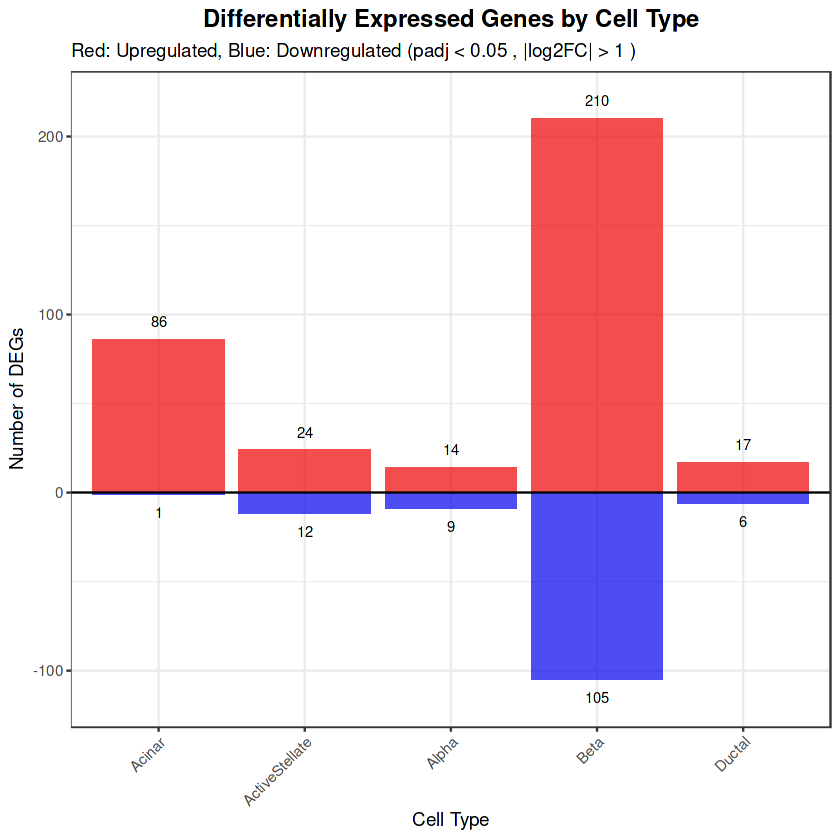

In [8]:
# === SUMMARY BAR PLOT ===
cat(" CREATING SUMMARY BAR PLOT\n")

# Bar plot of DEG counts
summary_plot <- ggplot(summary_stats, aes(x = cell_type)) +
  geom_col(aes(y = upregulated), fill = "red2", alpha = 0.7, position = "identity") +
  geom_col(aes(y = -downregulated), fill = "blue2", alpha = 0.7, position = "identity") +
  geom_text(aes(y = upregulated + 10, label = upregulated), size = 3) +
  geom_text(aes(y = -downregulated - 10, label = downregulated), size = 3) +
  labs(
    title = "Differentially Expressed Genes by Cell Type",
    x = "Cell Type",
    y = "Number of DEGs",
    subtitle = paste("Red: Upregulated, Blue: Downregulated (padj <", PVALUE_THRESHOLD, ", |log2FC| >", LOG2FC_THRESHOLD, ")")
  ) +
  theme_bw() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  geom_hline(yintercept = 0, linetype = "solid", color = "black")

print(summary_plot)

cat("\n Summary plot displayed above!\n")

In [9]:
# === FINAL ANALYSIS SUMMARY ===
cat(" ANALYSIS COMPLETE!\n")

# Calculate timing
end_time <- Sys.time()
total_time <- end_time - start_time

cat("\n GENERATED OUTPUTS:\n")
cat("✓ Summary statistics table\n")
cat("✓ Volcano plots for", length(all_deg_data), "cell types\n")
cat("✓ Comparative analysis (shared & specific genes)\n")
cat("✓ Gene lists for functional analysis (", length(gene_lists), "lists)\n")
cat("✓ Summary bar plot\n")

cat("\n  TIMING SUMMARY:\n")
cat("Analysis started:", format(start_time), "\n")
cat("Analysis completed:", format(end_time), "\n")
cat("Total execution time:", total_time, "\n")
cat("Total time in minutes:", round(as.numeric(total_time, units = "mins"), 2), "\n")

 ANALYSIS COMPLETE!

 GENERATED OUTPUTS:
✓ Summary statistics table
✓ Volcano plots for 5 cell types
✓ Comparative analysis (shared & specific genes)
✓ Gene lists for functional analysis ( 10 lists)
✓ Summary bar plot

  TIMING SUMMARY:
Analysis started: 2025-06-25 14:15:32 
Analysis completed: 2025-06-25 14:16:35 
Total execution time: 1.053182 
Total time in minutes: 1.05 


## Your Downstream Analysis Starts Here!!

### **Primary DEG Characterization**

### **Functional Enrichment Analysis**
- **Gene Ontology (GO) enrichment** - Biological processes, molecular functions, cellular components
- **KEGG pathway analysis** - Metabolic and signaling pathway overrepresentation
- **Reactome pathway mapping** - Detailed biochemical reaction networks
- **Gene Set Enrichment Analysis (GSEA)** - Rank-based functional analysis using full gene lists
- **Custom pancreatic gene sets** - Diabetes, insulin signaling, pancreatic development signatures

### **Comparative Cell Type Analysis**

### **Pathway and Network Analysis**

### **Integration with External Data**

### **Validation and Follow-up Studies**
